In [1]:
import os
import pandas as pd
import umap

from pathlib import Path

import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import logging

import matplotlib.pyplot as plt
from cycler import cycler

import torchvision
from torchvision import transforms
from torchvision.transforms import v2

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import pytorch_metric_learning
from pytorch_metric_learning import miners, losses, testers, trainers, samplers
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

2024-02-28 17:07:29.271259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 17:07:29.271507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 17:07:29.670210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 17:07:30.346412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 17:07:33.475796: W tensorflow/compiler/tf2

## TODO:
- [x] Visualize datapoints from the torch.Dataset
- [ ] Visualize some triplets (to make sure it gets harder and harder)
- [x] Visualize the embeddings to make sure it gets better clustered
- [x] UMAP and t-SNE on train set and test set
- [ ] Hyperparameter tuning
- [ ] Add evaluation metrics using AccuracyCalculator for instance, using precision_at_k
- [x] split into trunk and embedder
- [x] Add a visualizer hook after each epoch
- [x] Have an optimizer different for trunk and embedder
- [x] Make it work with tensorboard
- [x] Missing normalization from ImageNet
- [x] Use a Sampler MPerClass to balance the dataset and metric learning

In [2]:
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.4.1


## Loading the Dataset

In [3]:
def load_datasplit(
    split_type: str, 
    dataset_size: str, 
    split_root_dir: Path = Path("../../../data/04_feature/bearidentification/bearid/split/"),
) -> pd.DataFrame:
    """
    args:
    split_type in {by_individual by_provided_bearid}
    dataset_size in {nano, small, medium, large, xlarge, full}

    Returns a dataframe with the loaded datasplit
    """
    filepath = split_root_dir / split_type / dataset_size / "data_split.csv"
    return pd.read_csv(filepath, sep=";")


def make_id_mapping(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a dataframe that maps a bear label (eg. bf_755) to a unique natural number (eg. 0).
    The dataFrame contains two columns, namely id and label.
    """
    return pd.DataFrame(list(enumerate(df["bear_id"].unique())), columns=["id", "label"])

In [4]:
split_type = "by_provided_bearid"
#split_type = "by_individual"
dataset_size = "nano"
df = load_datasplit(split_type=split_type, dataset_size=dataset_size)

df_train =  df[df["split"] == "train"]
df_val = df[df["split"] == "val"]
df_test = df[df["split"] == "test"]

id_mapping = make_id_mapping(df)
id_mapping

,id,label
0,0,bf_775
1,1,bf_151
2,2,bf_480
3,3,bf_409
4,4,bf_410


## Model data preparation

In [5]:
class BearCircleLossDataset(Dataset):
    def __init__(self, dataframe, id_mapping, transform=None):
        self.dataframe = dataframe
        self.id_mapping = id_mapping
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = self.dataframe.iloc[idx]
        # TODO: remove the relative part here
        image_path = "../../../" + sample.path
        bear_id = sample.bear_id

        id_value = self.id_mapping.loc[self.id_mapping['label'] == bear_id, 'id'].iloc[0]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, id_value

In [6]:
# Values taken from documentation: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights
# Used for the Trunk model, here a ResNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_crop_size = (224, 224)

simple_transform = transforms.Compose([
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize(imagenet_crop_size),
    transforms.ColorJitter(hue=0.1, saturation=(0.9, 1.1)),  # Taken from Dolphin ID
    v2.RandomRotation(10),                                   # Taken from Dolphin ID
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [7]:
# Inference Transforms available here:
models.ResNet18_Weights.IMAGENET1K_V1.transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224)

In [8]:
batch_size = 32

train_dataset_without_transform = BearCircleLossDataset(df_train, id_mapping, transform=simple_transform)
train_loader_without_transform = DataLoader(train_dataset_without_transform, batch_size=batch_size, shuffle=True, drop_last=True)

train_dataset = BearCircleLossDataset(df_train, id_mapping, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = BearCircleLossDataset(df_val, id_mapping, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = BearCircleLossDataset(df_test, id_mapping, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Visualization of the dataset

### Visualize without data augmentation and transform

image tensor: torch.Size([32, 3, 300, 300])
class labels: tensor([2, 2, 2, 4, 2, 3, 0, 1, 2, 2, 2, 2, 3, 0, 0, 1, 1, 2, 4, 4, 0, 0, 2, 0,
        3, 4, 1, 1, 1, 4, 0, 2])


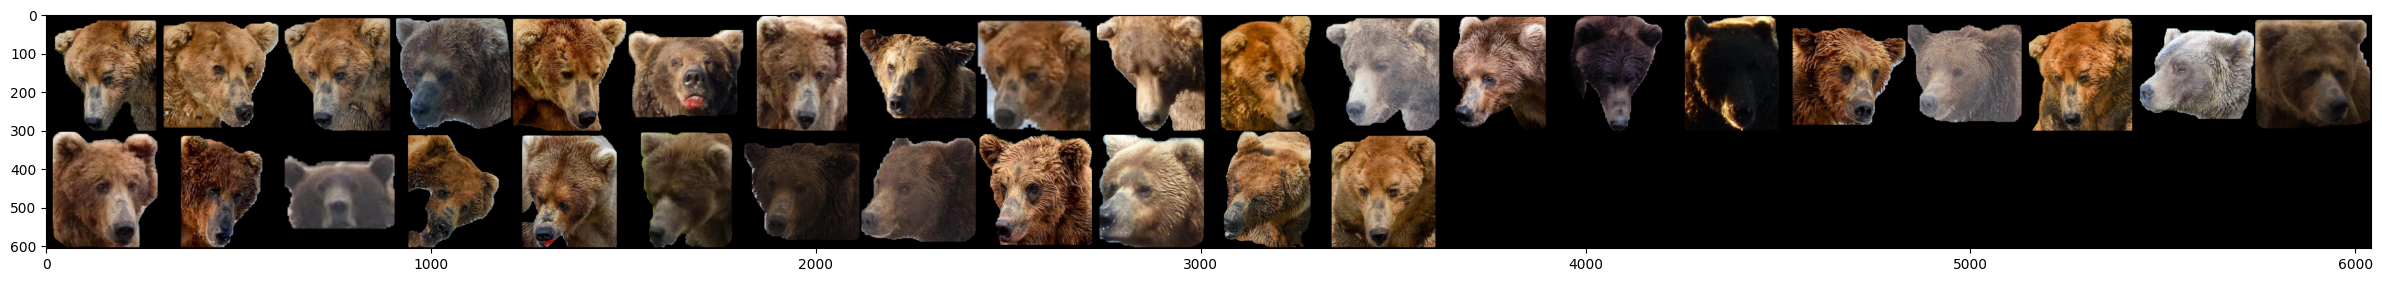

In [9]:
sample = next(iter(train_loader_without_transform))

imgs, lbls = sample

# create a grid 
plt.figure(figsize=(30, 15))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
# plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');
plt.imshow(np.transpose(grid, axes=(1,2,0)));

### Visualize with data augmentation and transform

image tensor: torch.Size([32, 3, 224, 224])
class labels: tensor([4, 0, 1, 0, 2, 3, 3, 1, 0, 1, 0, 4, 2, 2, 0, 0, 2, 2, 0, 0, 4, 3, 1, 1,
        3, 1, 3, 0, 0, 2, 3, 1])


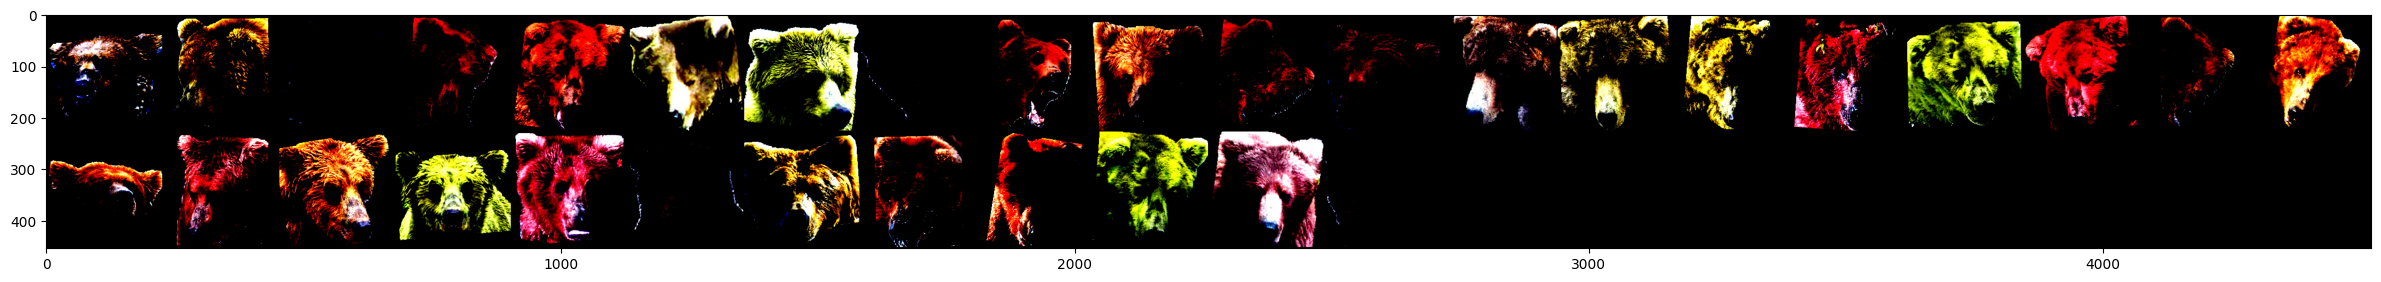

In [10]:
sample = next(iter(train_loader))

imgs, lbls = sample

# create a grid 
plt.figure(figsize=(30, 15))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
# plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');
plt.imshow(np.transpose(grid, axes=(1,2,0)));

## Model

### Device selection

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
dataset_dict = {
    "val": val_dataset,
    "test": test_dataset,
    "train": train_dataset,
}

experiment_number = 0
experiment_name = f"experiment_{experiment_number}_loss_circleloss_size_{dataset_size}_split_{split_type}"
record_path = Path('../../../data/06_models/bearidentification/metric_learning/') / experiment_name

record_keeper, _, _ = logging_presets.get_record_keeper(
    csv_folder= record_path / "training_logs", 
    tensorboard_folder= record_path / "tensorboard",
    experiment_name=experiment_name,
)

hooks = logging_presets.get_hook_container(record_keeper)

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    epoch = args[0]
    logging.info(
        f"UMAP plot - {split_name} split and label set {keyname} - epoch {epoch}"
    )
    logging.info(f"args: {args}")
   
    
    label_set = np.unique(labels)
    num_classes = len(label_set)
    
    fig = plt.figure(figsize=(20, 15))
    ax = plt.gca()
    ax.set_title(f"UMAP plot - {split_name} split and label set {keyname} - epoch {epoch}")
    
    ax.set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=5)

    output_filepath = record_path / "embeddings" / f"umap_{split_name}_epoch_{epoch}.png"
    os.makedirs(output_filepath.parent, exist_ok=True)
    
    plt.savefig(output_filepath)
    plt.show()


tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=2,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

In [13]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i <= final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
                layer_list.append(nn.BatchNorm1d(input_size))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [14]:
# Trunk
trunk = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
trunk_output_size = trunk.fc.in_features
trunk.fc = nn.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Embedder
emb_size = 128
hidden_layer_size = 1024
embedder = torch.nn.DataParallel(MLP([trunk_output_size, hidden_layer_size, emb_size]).to(device))

models_dict = {
    "trunk": trunk, 
    "embedder": embedder,
}

In [15]:
print(embedder)

DataParallel(
  (module): MLP(
    (net): Sequential(
      (0): ReLU()
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=1024, out_features=128, bias=True)
    )
    (last_linear): Linear(in_features=1024, out_features=128, bias=True)
  )
)


In [16]:
embedder_config = {"lr": 0.001, "weight_decay": 1e-5}
trunk_config = {"lr": 0.0001, "weight_decay": 1e-5}

embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=embedder_config["lr"], weight_decay=embedder_config["weight_decay"])
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=trunk_config["lr"], weight_decay=trunk_config["weight_decay"])

optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
}

In [17]:
metric_config = {"m": 0.4, "gamma": 256}

metric_loss = losses.CircleLoss(
    m=metric_config["m"], 
    gamma=metric_config["gamma"],
)

loss_funcs = {
    "metric_loss": metric_loss
}

miner_config = {"pos_strategy": "semihard", "neg_strategy": "hard"}

# mining_func =  miners.BatchEasyHardMiner(pos_strategy=miner_config["pos_strategy"], neg_strategy=miner_config["neg_strategy"])
tuple_miner =  miners.BatchEasyHardMiner(pos_strategy=miner_config["pos_strategy"], neg_strategy=miner_config["neg_strategy"])
mining_funcs = {
    "tuple_miner": tuple_miner,
}

# labels = train_dataset.id_mapping["id"].tolist()
label_to_bear_id = id_mapping["label"].to_dict()
bear_id_to_label = {v: k for k, v in label_to_bear_id.items()}
labels = train_dataset.dataframe["bear_id"].map(lambda bear_id: bear_id_to_label[bear_id]).to_list()

# TODO
sampler_config = {}

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    labels=labels, 
    m=4,
    length_before_new_iter=len(train_dataset),
)

In [18]:
model_folder = Path("../../../data/06_models/bearidentification/metric_learning") / experiment_name

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, 
    dataset_dict, 
    model_folder, 
    test_interval=1, 
    patience=10,
)

In [19]:
trainer = trainers.MetricLossOnly(
    models_dict,
    optimizers,
    batch_size,
    loss_funcs,
    train_dataset,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=2,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=26.71197: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:55<00:00,  2.42s/it]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the train split
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.07it/s]
INFO:PML:Getting embeddings for the test split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.09it/s]
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]
INFO:PML:Running UMAP on the train set
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/pytho

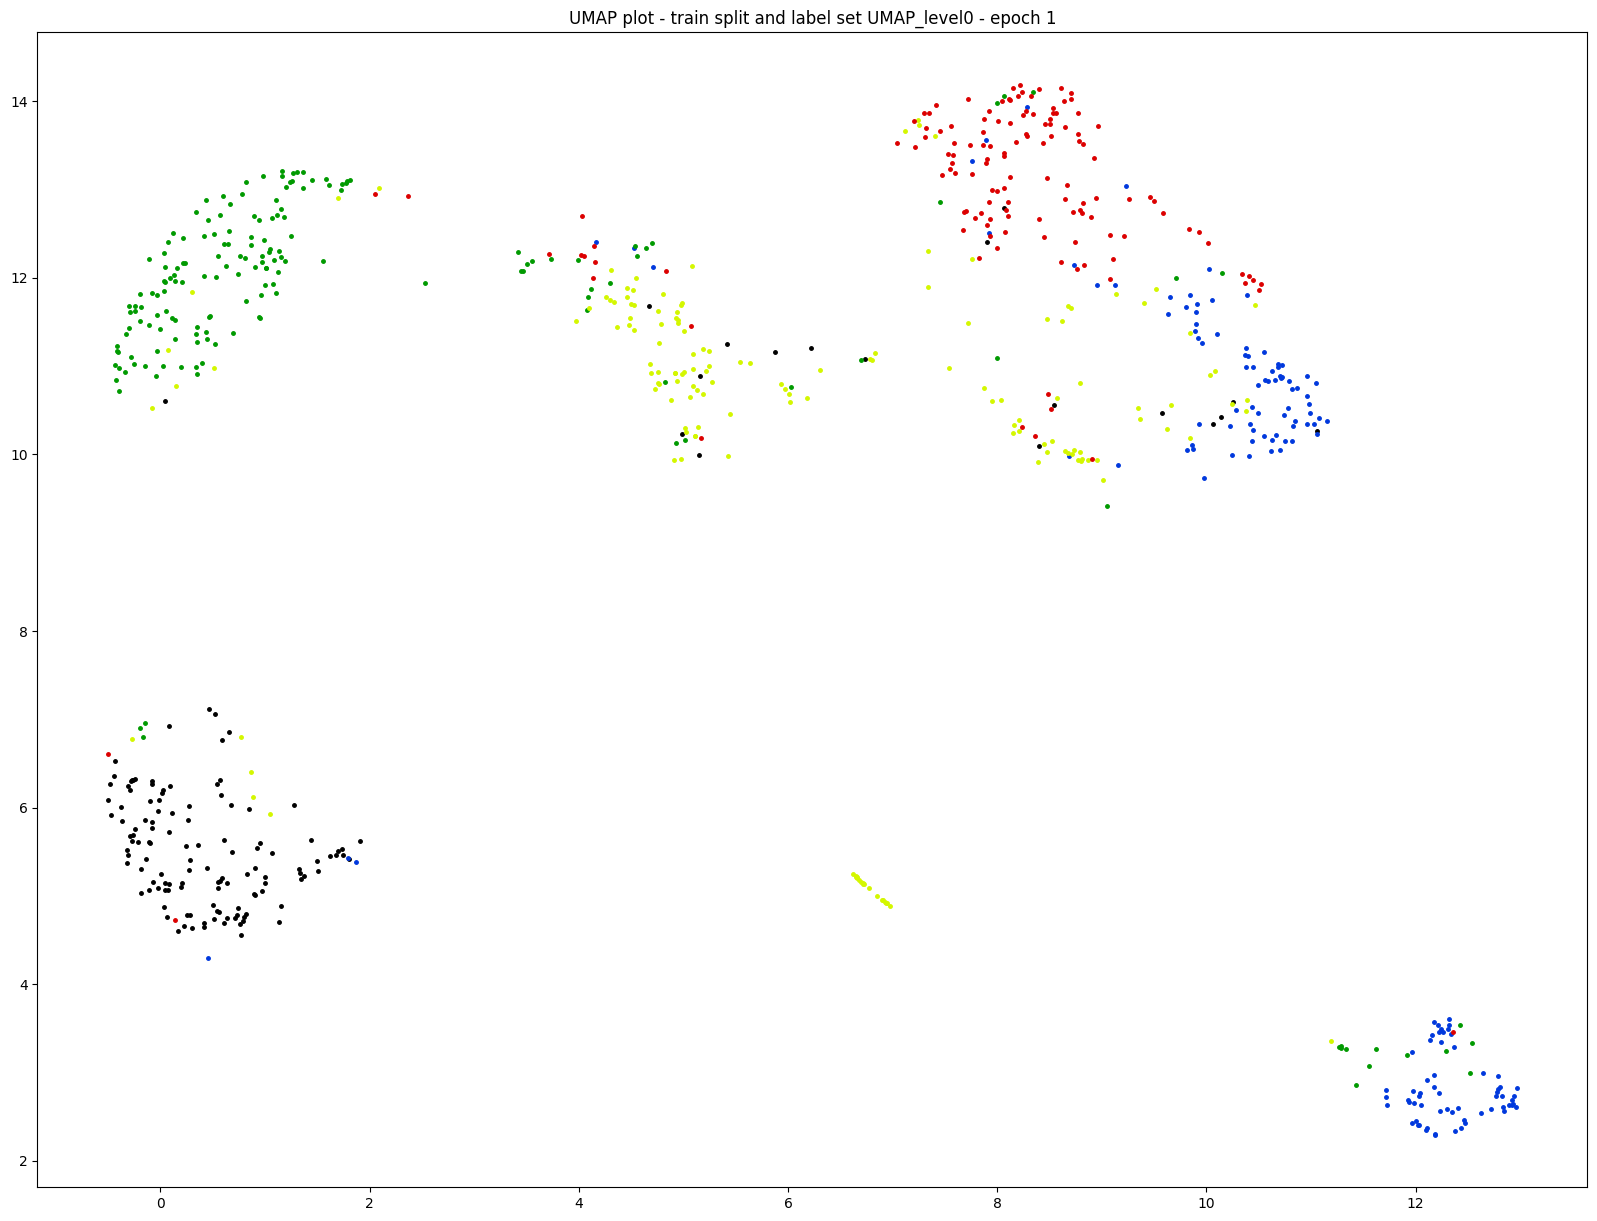

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot - test split and label set UMAP_level0 - epoch 1
INFO:root:args: (1,)


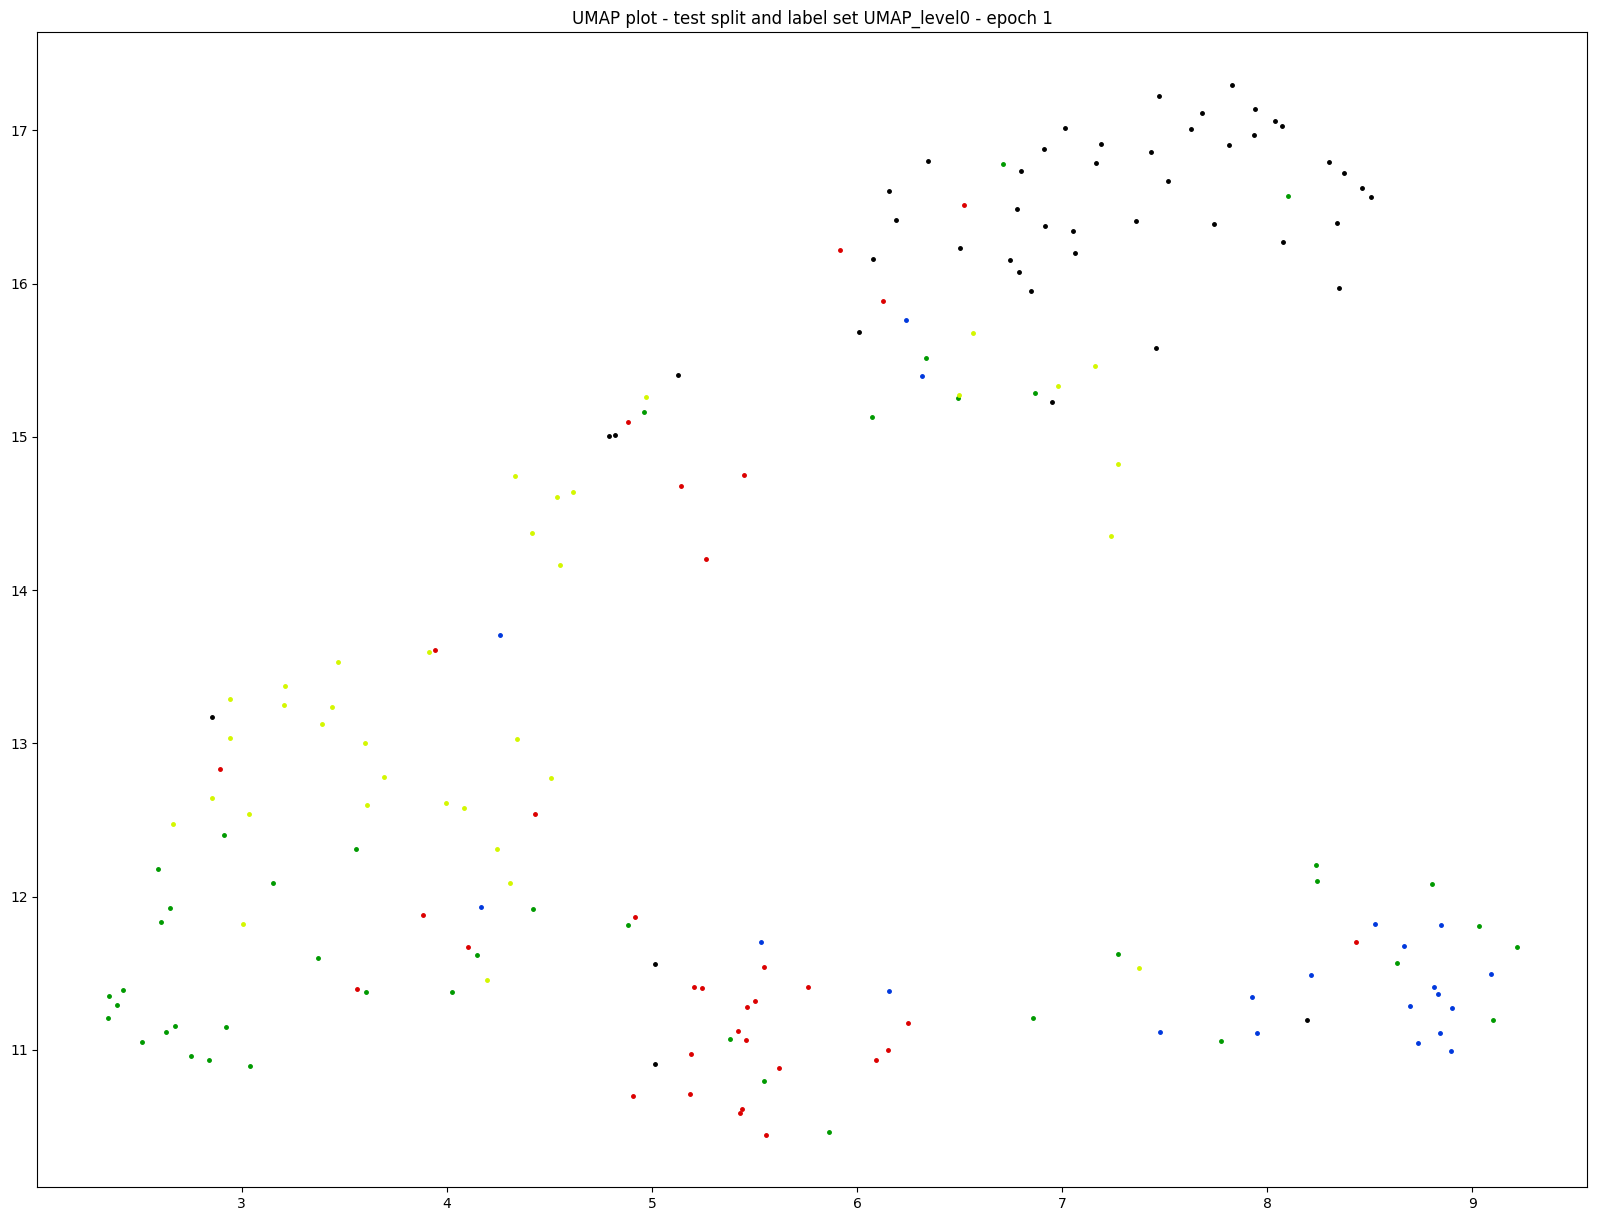

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot - val split and label set UMAP_level0 - epoch 1
INFO:root:args: (1,)


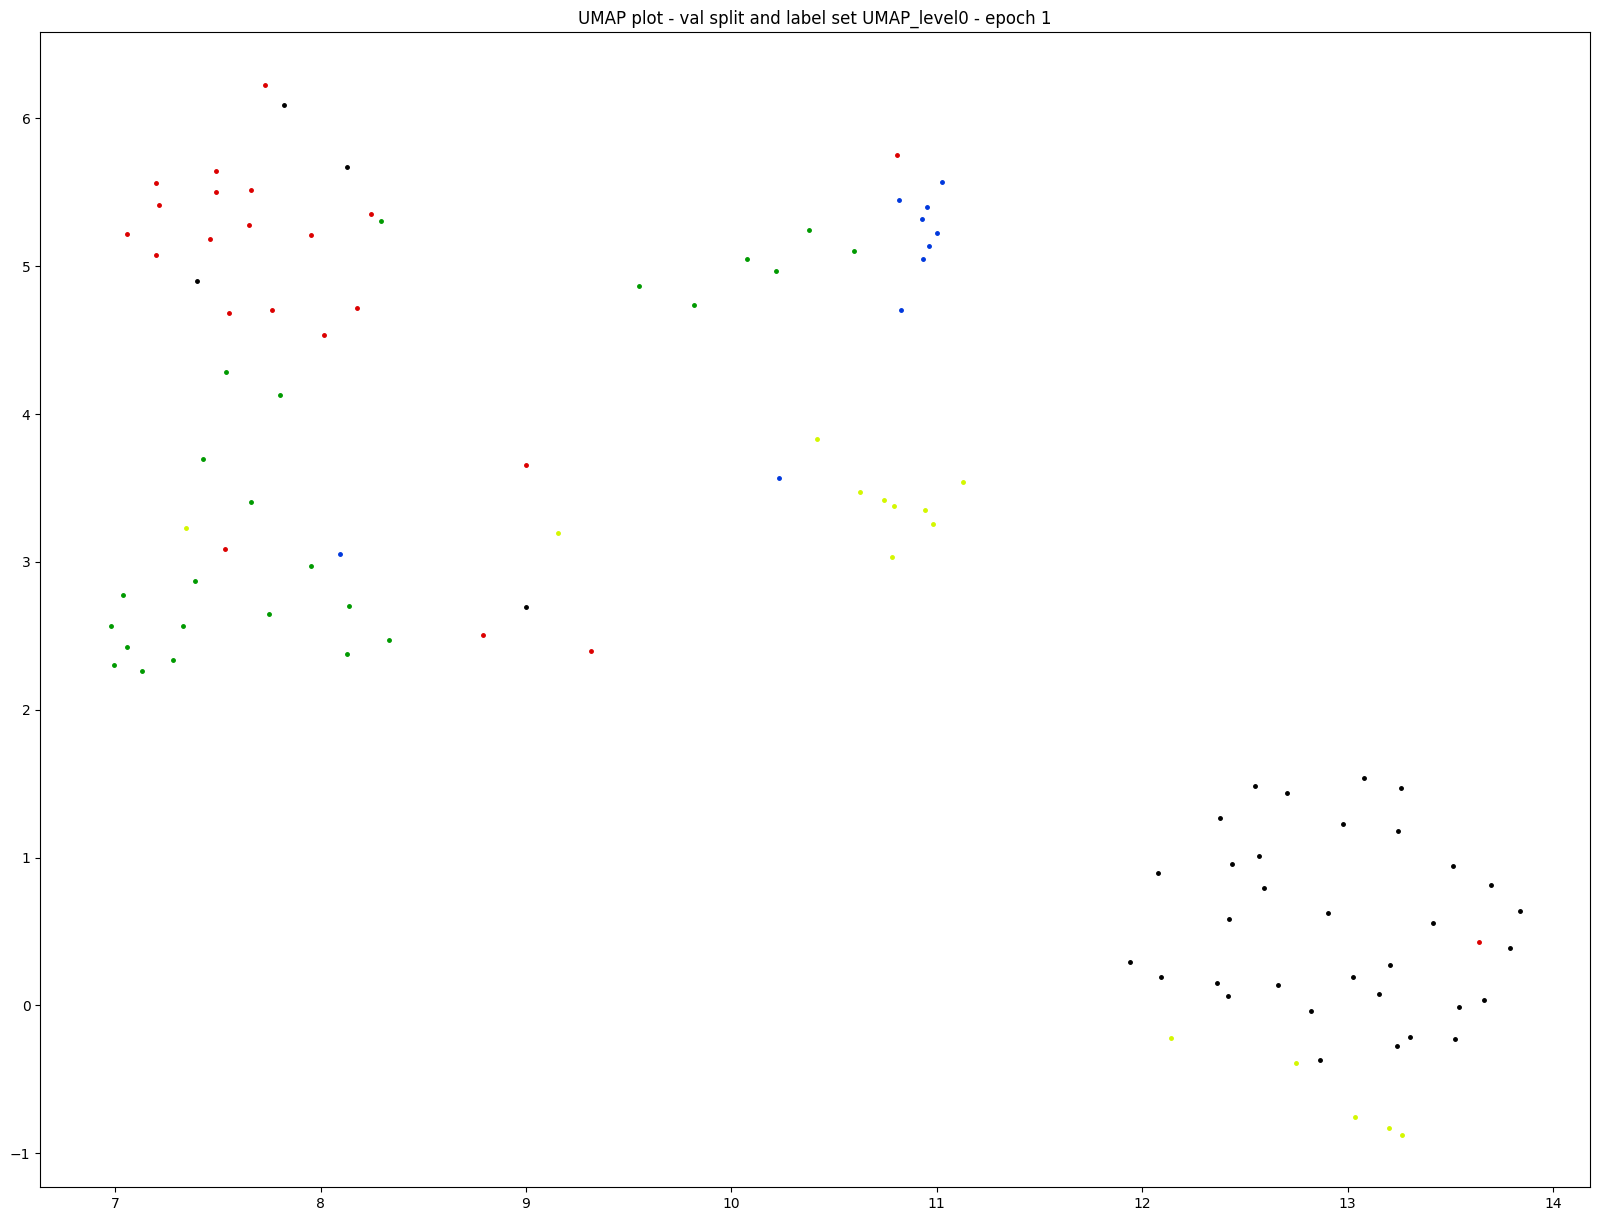

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=37
INFO:PML:embedding dimensionality is 128
/home/chouffe/miniconda3/envs/fruitpunch_bears/lib/python3.9/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
INFO:PML:running k-means clustering with k=5
INFO:PML:embedding dimensionality is 128
WARNING clustering 108 points to 5 centroids: please provide at least 195 training points
INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=47
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=5
INFO:PML:embedding dimensionality is 128
WARNING clustering 179 poi

In [20]:
trainer.train(num_epochs=1)

INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the train split
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:23<00:00,  1.02it/s]
INFO:PML:Getting embeddings for the test split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]
INFO:PML:Getting embeddings for the val split
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]
INFO:PML:Running UMAP on the train set
INFO:PML:Finished UMAP
INFO:root:UMAP plot - train split and label set UMAP_level0 - epoch 3
INFO:root:args: (3,)


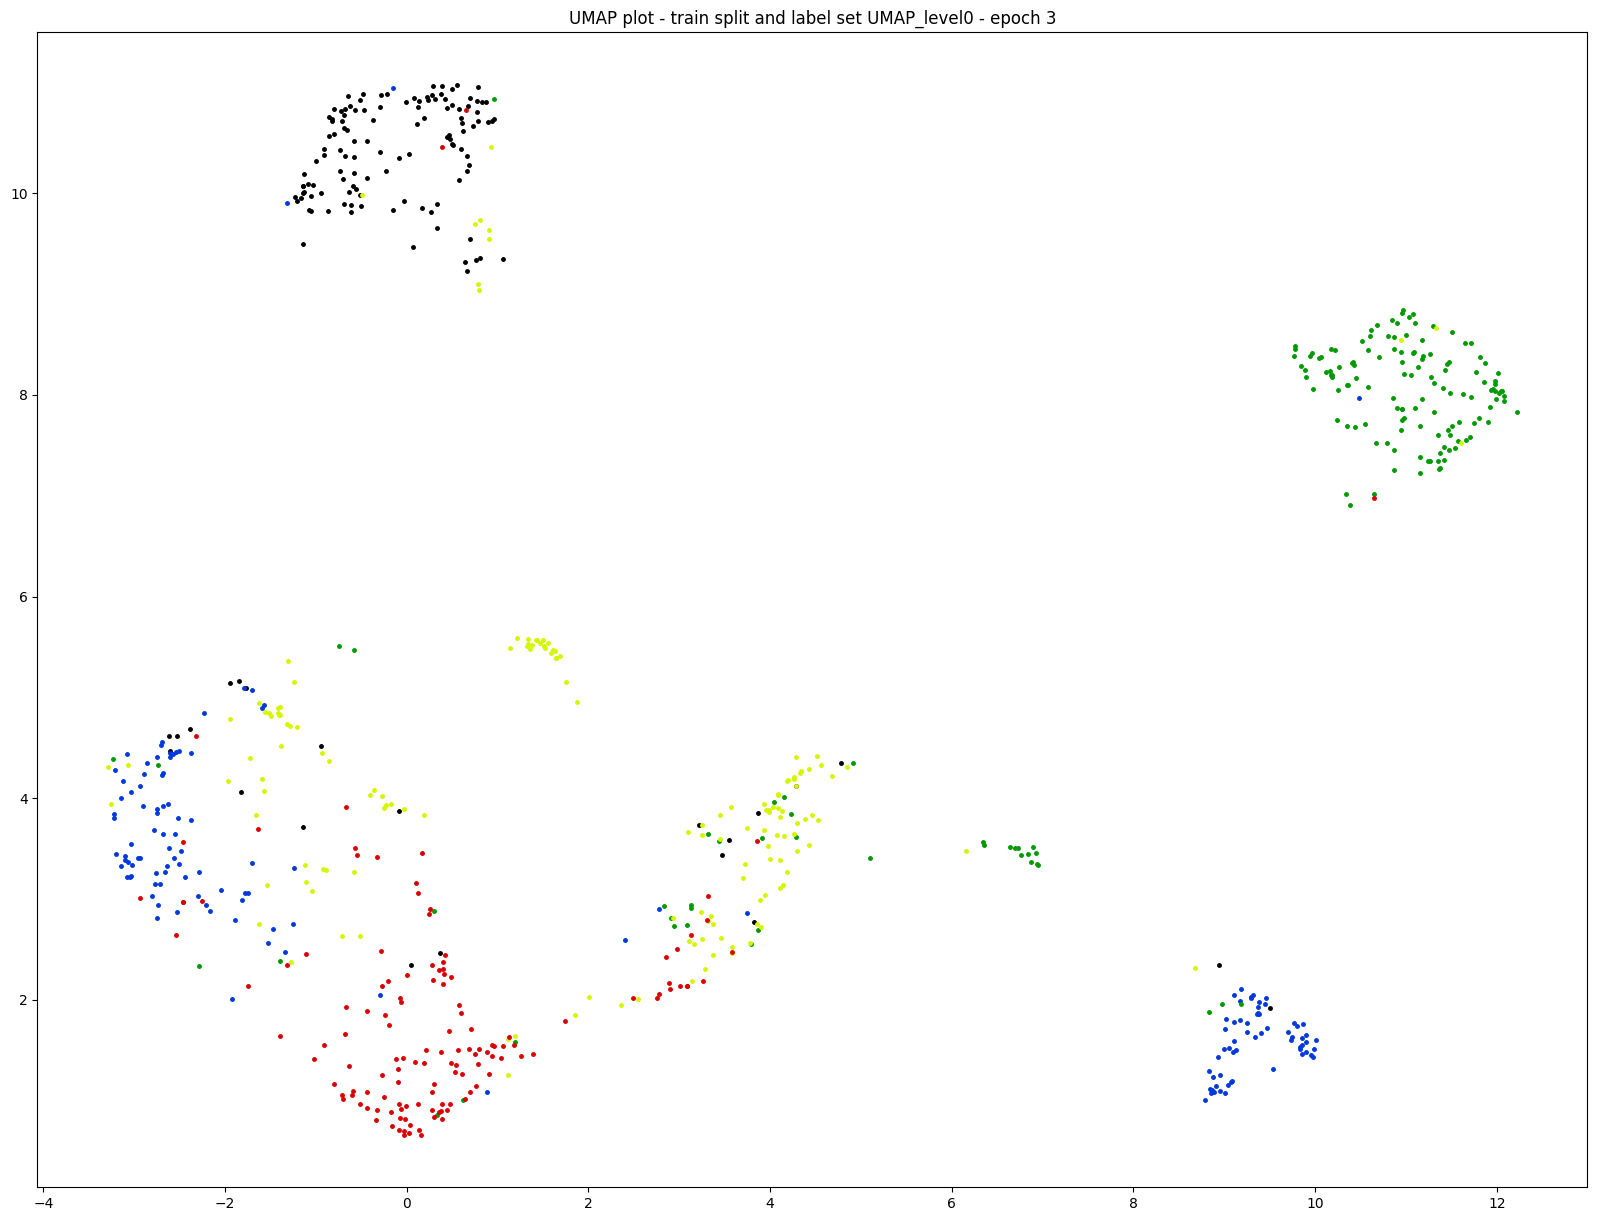

INFO:PML:Running UMAP on the test set
INFO:PML:Finished UMAP
INFO:root:UMAP plot - test split and label set UMAP_level0 - epoch 3
INFO:root:args: (3,)


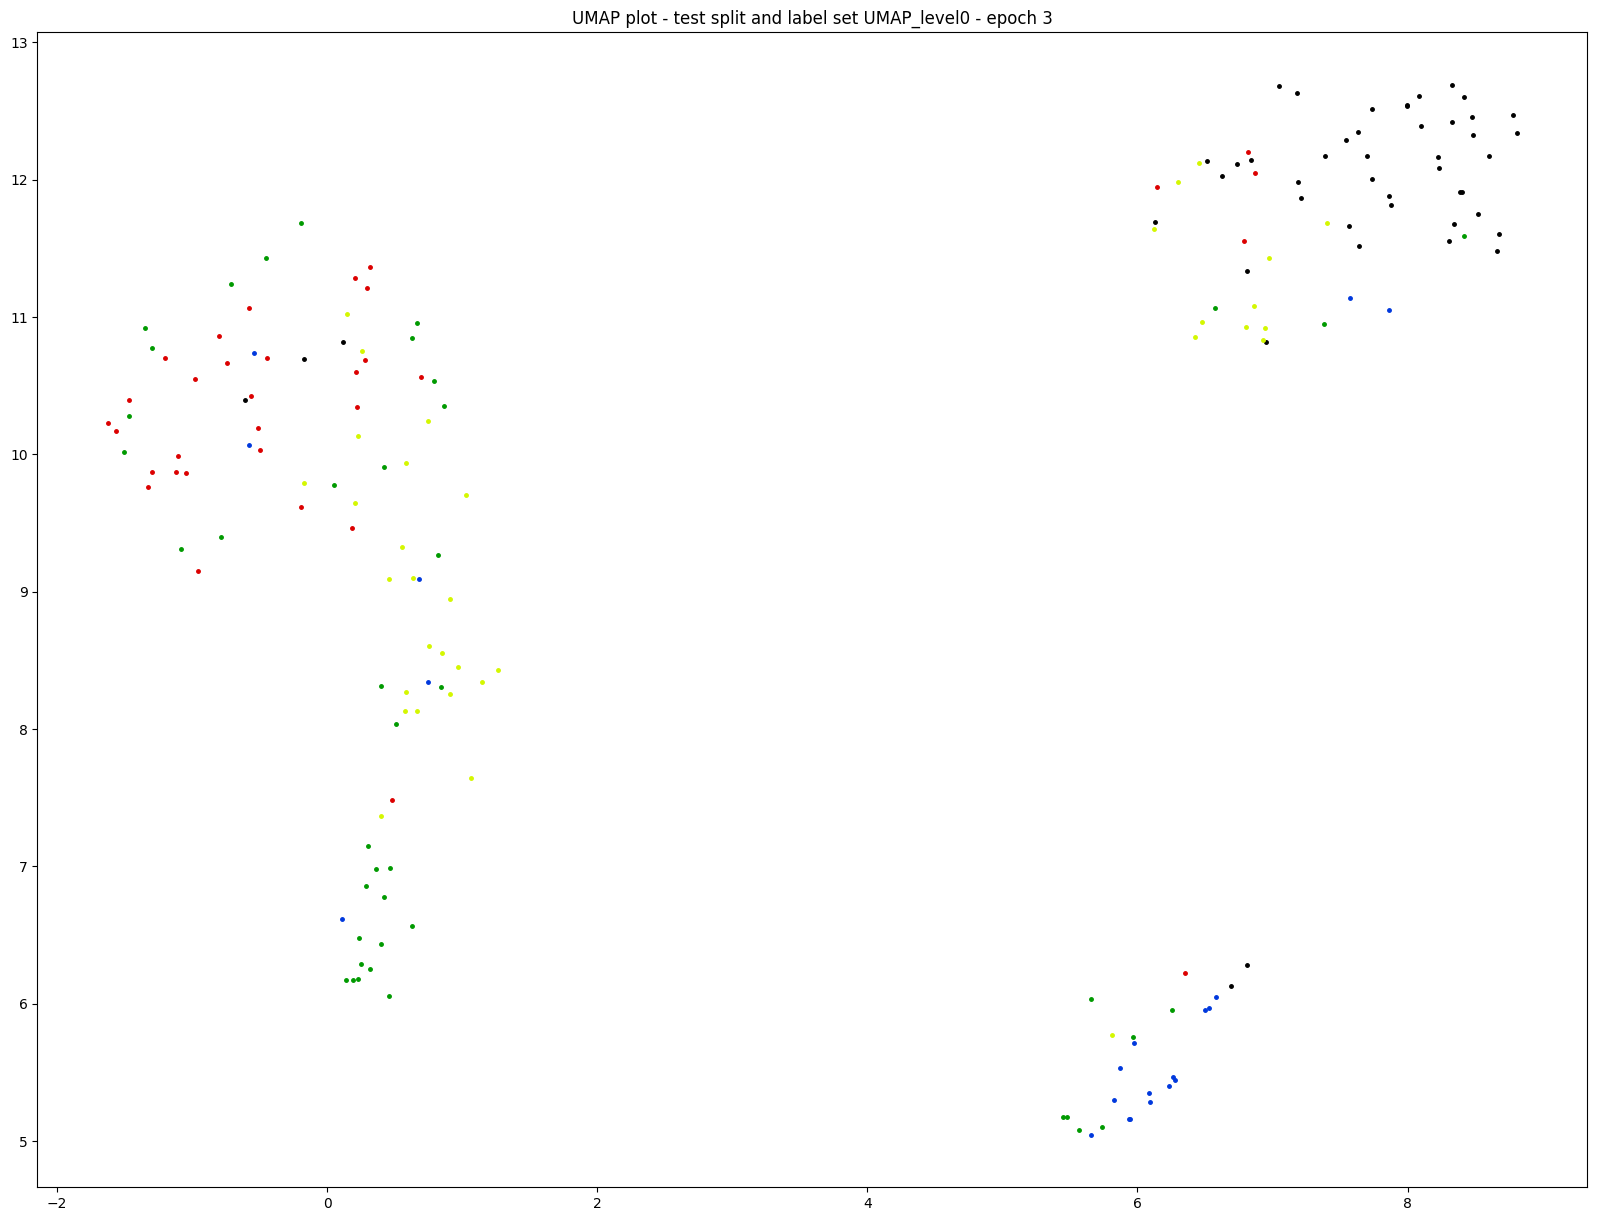

INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot - val split and label set UMAP_level0 - epoch 3
INFO:root:args: (3,)


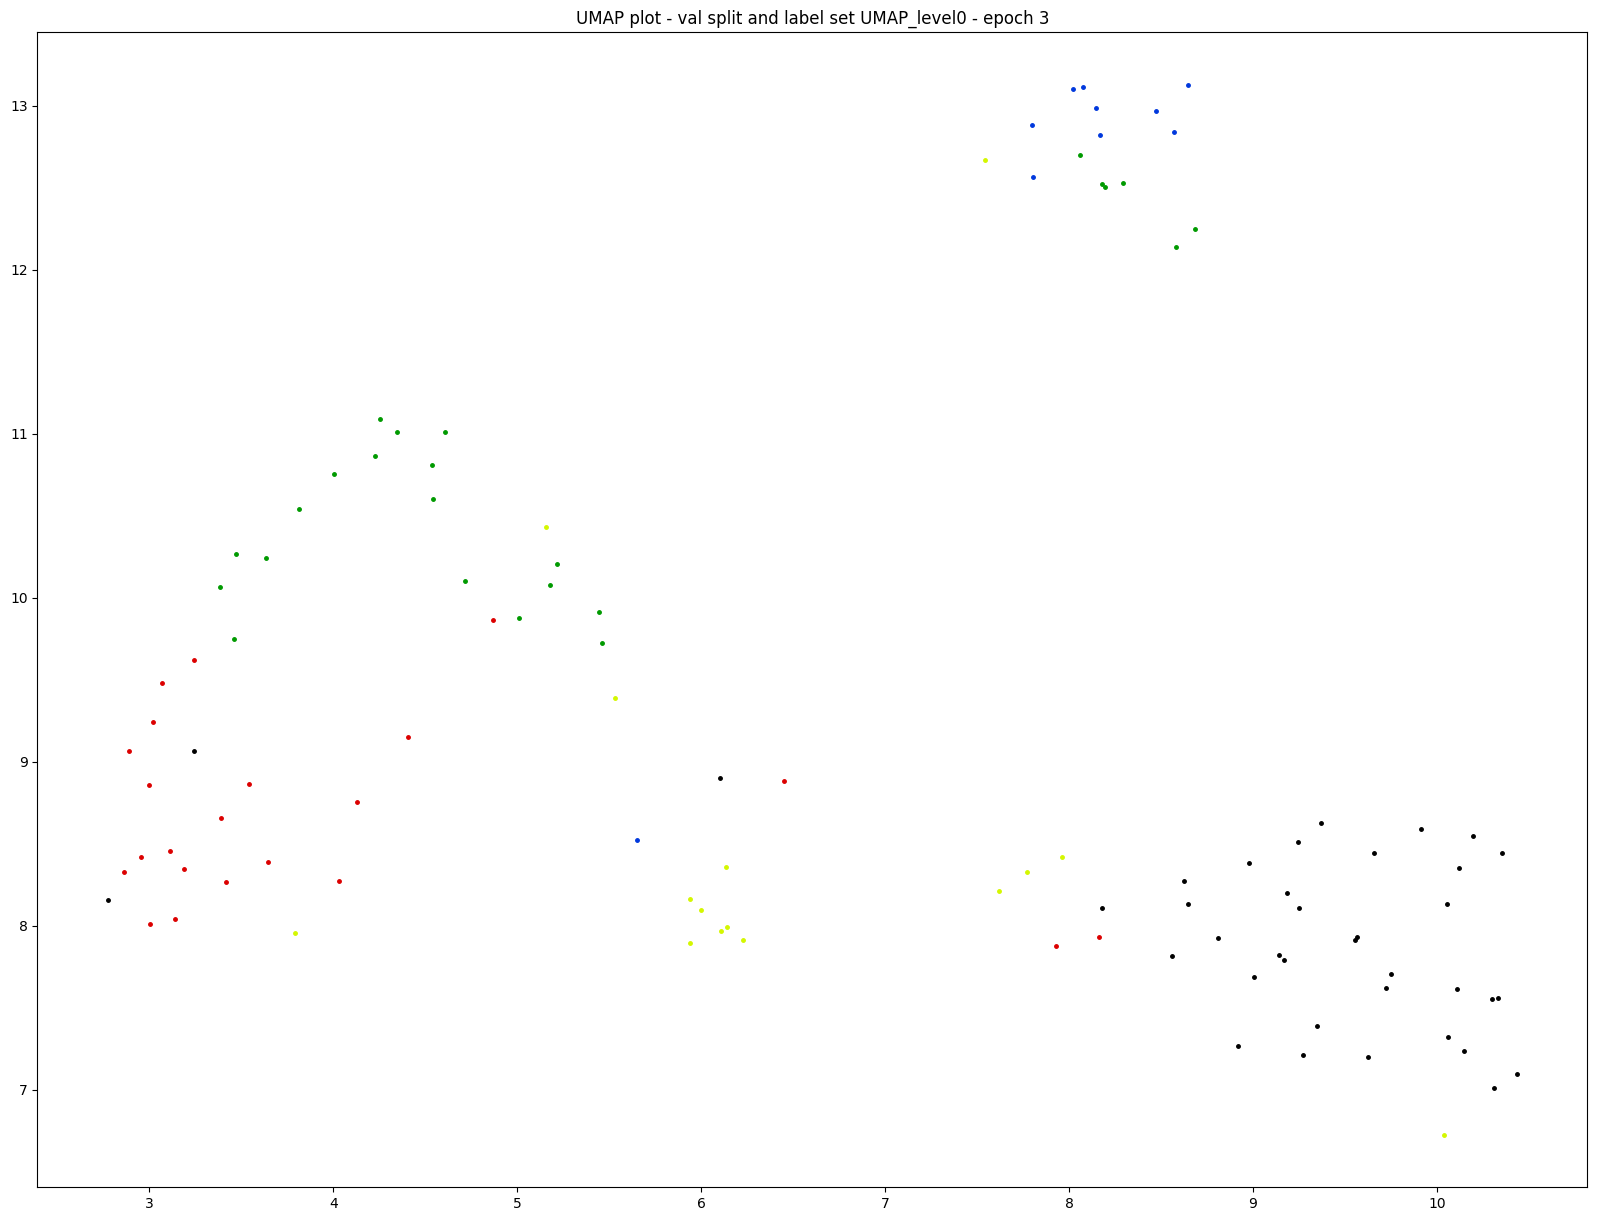

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=37
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=5
INFO:PML:embedding dimensionality is 128
WARNING clustering 108 points to 5 centroids: please provide at least 195 training points
INFO:PML:Computing accuracy for the test split w.r.t ['test']
INFO:PML:running k-nn with k=47
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=5
INFO:PML:embedding dimensionality is 128
WARNING clustering 179 points to 5 centroids: please provide at least 195 training points
INFO:PML:Computing accuracy for the train split w.r.t ['train']
INFO:PML:running k-nn with k=174
INFO:PML:embedding dimensionality is 128
INFO:PML:running k-means clustering with k=5
INFO:PML:embedding dimensionality is 128


defaultdict(dict,
            {'val': {'epoch': 3,
              'AMI_level0': 0.6411012272989854,
              'NMI_level0': 0.6602202809286862,
              'mean_average_precision_level0': 0.6083796722255035,
              'mean_average_precision_at_r_level0': 0.5619940807580028,
              'mean_reciprocal_rank_level0': 0.8963358998298645,
              'precision_at_1_level0': 0.8703703703703703,
              'r_precision_level0': 0.6244839991820668},
             'test': {'epoch': 3,
              'AMI_level0': 0.29835167892107184,
              'NMI_level0': 0.3194412408175067,
              'mean_average_precision_level0': 0.37606074200126716,
              'mean_average_precision_at_r_level0': 0.34854395764869445,
              'mean_reciprocal_rank_level0': 0.7604465484619141,
              'precision_at_1_level0': 0.6703910614525139,
              'r_precision_level0': 0.4631444592653675},
             'train': {'epoch': 3,
              'AMI_level0': 0.529522953970846

In [21]:
tester.test(
    dataset_dict=dataset_dict, 
    epoch=3, 
    trunk_model=models_dict["trunk"],
    embedder_model=models_dict["embedder"],
)